# Test case on realistic scales
This notebooks constructs a case where the grid size, and noise/correlation scales are "realistic".

In [1]:
# Import modules
using Distributions, Random
using LinearAlgebra
using Plots

# Import seismic modules
using seismic.Grids
using seismic.Rays
using seismic.Visualization
using seismic.Inversion

In [2]:
Random.seed!(123); # Setting the seed

In [3]:
# Construct grid
m=1.0e-3;km = 1000m; s=1.0; ms=1e-3s  # Units
physical_dims = Point(3000km, 2000km)
n_cells = Point(20, 15)
Δx = physical_dims.x / n_cells.x; Δy = physical_dims.y / n_cells.y
grid = makeGrid(n_cells.x, n_cells.y, Δx, Δy);

In [4]:
# Define source location
sx = 0.0
sy = physical_dims.y / 2
src = Point(sx, sy)

# Distribute floats:
gx = grid.xticks; gy = grid.yticks
n_recs = round(Int, physical_dims.x * physical_dims.y / (300km)^2)
rx = rand(Uniform(minimum(gx.+0.1Δx),maximum(gx.-0.1Δx)),n_recs)
ry = rand(Uniform(minimum(gy.+0.1Δy),maximum(gy.-0.1Δy)),n_recs)
recs = Point{Float64}[]
for i in 1:n_recs
    push!(recs,Point(rx[i], ry[i]))
end

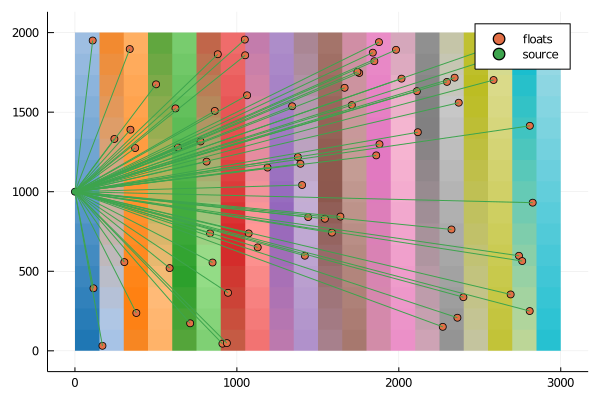

In [5]:
plot_grid_rays(grid,src,recs,show_float_label=false,show_gridbox_label=false)

In [6]:
# receivers-pairs mapping
M = receiverPairs(recs, src, max_degrees = 10, max_distance=1000km);
# distance matrix
D = distanceMatrix(recs, src, grid);
# relative distance matrix
E = relativeDistanceMatrix(M,D);

In [7]:
println("$(size(M)[2]) floats. Number of pairs: $(size(M)[1])")

67 floats. Number of pairs: 296


In [8]:
## Compute uncertainty matrix
wave_speed = 1.5km/s  # Mean T-wave speed
slowness = 1 / wave_speed
eddy_size = 300km   # typical eddy size

# Prior (solution) slowness variance Rxx, Units: [seconds / meter]
σxx = 2e-4s/km
# spatial decorrelation scale. Units: [m]
λ = eddy_size

# Prior measurement variance Rnn, units: [seconds]
σnn = 100m       # uncertainty in position of resurfacing float
σ_indp = 10ms  # independent TT noise


rxx = Rxx(grid, σxx, λ)  # [(s/m)^2]
rnn = Rnn(M*slowness, σnn, σ_indp)  # [s^2]
ryy = Ryy(E, rxx, rnn)
P = uncertaintyMatrix(E, rxx, rnn);

println("Matrix condition number $(cond(E * rxx * E' + rnn))")
println("Prior solution variance: $(rxx[1,1])")

# Optionally resscale uncertainties below relative to prior uncertainty.
prior_variance_scale = σxx^2;
P = P / prior_variance_scale;

Matrix condition number 9648.998526119756
Prior solution variance: 4.0e-8


In [9]:
N = n_cells.x * n_cells.y;
sum(P) / N^2

0.011673222064156427

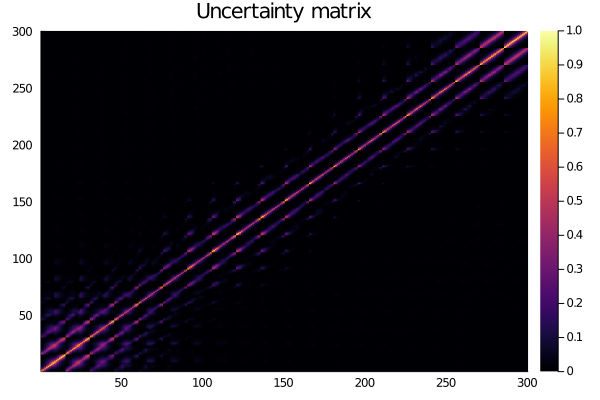

In [10]:
heatmap(P, clims=(0,1))
title!("Uncertainty matrix")

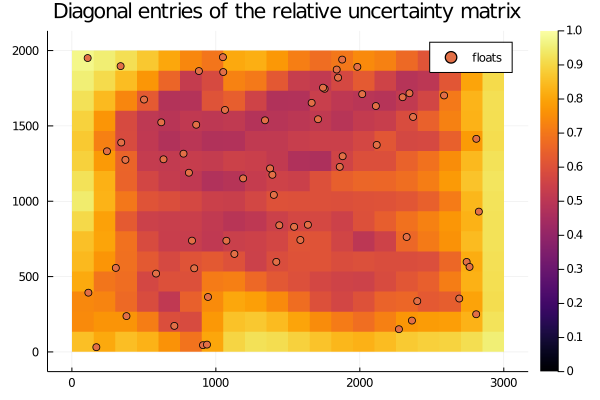

In [11]:
heatmap(grid.xticks,grid.yticks,reshape(diag(P),grid.ny,grid.nx), clims=(0,1))
scatter!(rx,ry,label="floats")
title!("Diagonal entries of the relative uncertainty matrix")

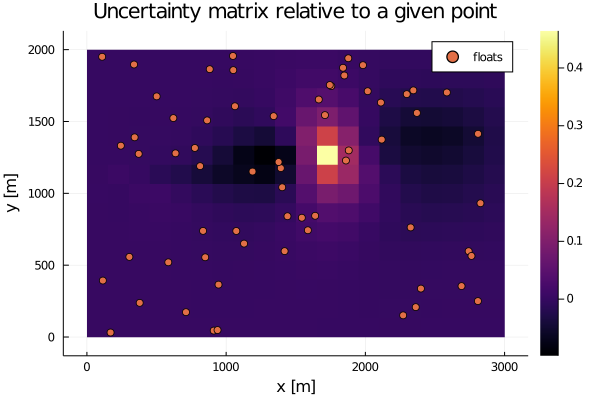

In [12]:
center_ind = 175;
heatmap(grid.xticks,grid.yticks,reshape(P[center_ind,:],grid.ny,grid.nx))
title!("Uncertainty matrix relative to a given point"); xlabel!("x [m]"); ylabel!("y [m]")
scatter!(rx,ry,label="floats")

In [13]:
sum(P)

1050.5899857740785

# Impose slowness perturbation field

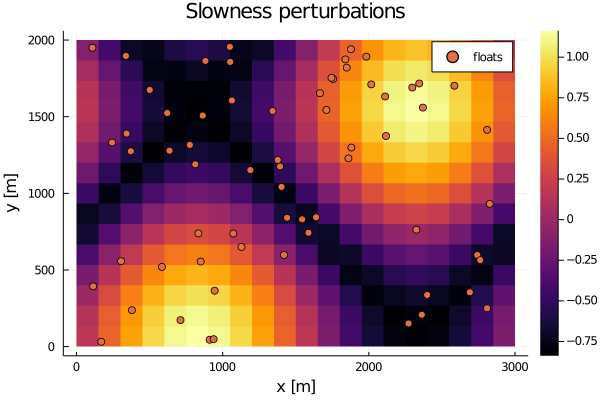

In [14]:
blob_scale = 1.

# Compute cell centers coordinates for convenience
xc = [ p.x for p in grid.centers ]; xcticks = sort(unique(xc))
yc = [ p.y for p in grid.centers ]; ycticks = sort(unique(yc))

wλ=grid.nx * grid.Δx / blob_scale;
f(x, y) = begin
    abs(sin.(2π/wλ*x) + cos.(2π/wλ*y))
end

Z = Array{Float64}(undef, length(grid.nodes))
for (i, node) in enumerate(grid.nodes)
    Z[i] = f(node.x, node.y)
end
Z = Z .- mean(Z)

heatmap(xcticks, ycticks, reshape(Z,grid.ny,grid.nx))
title!("Slowness perturbations"); xlabel!("x [m]"); ylabel!("y [m]")
scatter!(rx,ry,label="floats")

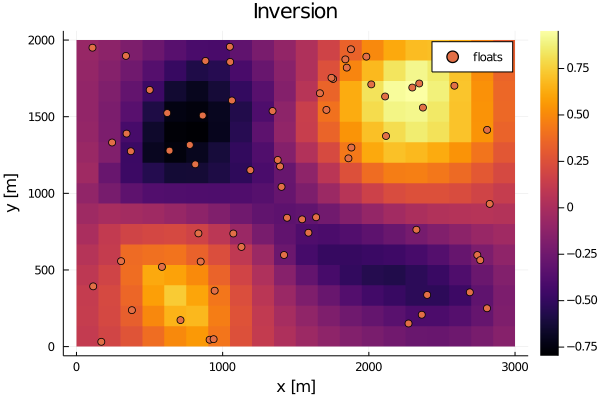

In [15]:
# Arrival times
τ = E * Z;

# solution
x̃ = computeInversion(E,rxx,rnn,τ);

heatmap(xcticks, ycticks, reshape(x̃,grid.ny,grid.nx))
title!("Inversion"); xlabel!("x [m]"); ylabel!("y [m]")
scatter!(rx,ry,label="floats")